## Linear Methods for Anomaly Detection
Anomaly detection can be done by the following linear models:
- Linear regression models
- Principal component analysis
- Support vector machines

**Why are these `linear` methods?**
- Example of linear function: y = a+bx
- Such function are foundation for both linear regression models and SVM. It provides the score for the anomaly detection.
- Linear functions are simple: if the original problem is non-linear, it is usually advantageous to transform it into a linear problem.
- Linear Map:
    - f(x+y) = f(x) + f(y)
    - f(cx) = cf(x)

## A. Imports

In [1]:
import numpy as np
np.set_printoptions(suppress=True, precision=4)

import sys
import matplotlib.pyplot as plt
import sklearn.decomposition as decomp
import sklearn.linear_model as linear_model
import sklearn.datasets as sk_data
from sklearn.preprocessing import StandardScaler
import numpy.linalg as nla
import sklearn.svm as svm
import pandas as pd

## B. Python and library versions

In [2]:
packages = [np]

msg = f"""
Python Version: {sys.version}

library .      version
-------        -------"""
print(msg)

for package in packages:
    print(f"{package.__name__:11}    {package.__version__:>7}")


Python Version: 3.11.5 (main, Sep 11 2023, 13:23:44) [GCC 11.2.0]

library .      version
-------        -------
numpy           1.23.5


## C. Section 1.  Linear Regression Models
- Linear regression models look for a relationship between dependent variables and independent variables.
- For simplicity, we will start with just one dependent and one independent variable.
- eg. 2D data: y vs. x
- input -> x -> hours studied
- output -> y -> grade

#### Discussion
- Vertical distance from a st. line  fit is used to score points.
    - Anomalies are far from line.
- Ideally, split the data into train and test datasets.
- Use the train data
    - to get the parameters of the st.line fit
    - determine the distance threshold for anomalies
- Apply the results to test data to detect anomalies

#### Scoring the Anomaly
- Often the square of the residuals is taken as a score.
    - Large values(either above or below the fit) are anomalies.
    
- Another approach is to use the z-score
    - Calculate the standard deviation of the residuals
    - The z-score is given by z = e/s.d

### 1. Data
Here we will work with the data shown in the lecture: exam grade and hours studied.

In [3]:
# Approximately linear data
exam_data1 = np.array([[1, 2, 3, 4, 5],
                    [57, 70, 76, 84, 91]]).T
print(exam_data1)

[[ 1 57]
 [ 2 70]
 [ 3 76]
 [ 4 84]
 [ 5 91]]


In [4]:
# One anomaly replaces a normal point
exam_data2 = np.array([[1, 2, 3, 4, 5],
                      [57, 70, 99, 84, 91]]).T # [3, 99] is anomalous data
print(exam_data2)

[[ 1 57]
 [ 2 70]
 [ 3 99]
 [ 4 84]
 [ 5 91]]


To simplify our work, we will introduce a helper function that plots a straight line given the slope, intercept, axes (to create the figure) and the style of the line (to plot multiple lines on the same graph).

In [5]:
def plot_mb(m, b, ax, style):
    'plot a line y=mx+b on a matplotlib axis'
    xs = ax.get_xlim()
    ax.plot(xs, m*xs + b, style) #style is type of line

### 2. Analysis
Plot the two datasets together so we can easily compare them.

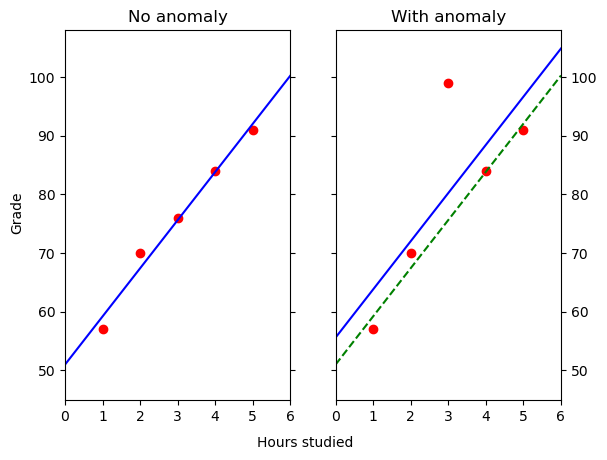

In [6]:
fig, axes = plt.subplots(1,2,sharex=True)

# Modify axes so they look nice
axes[0].set_xlim([0, 6.01])
start_x, end_x = axes[0].get_xlim()
stepsize_x = 1
axes[0].xaxis.set_ticks(np.arange(start_x, end_x, stepsize_x))
axes[0].yaxis.set_ticks_position('both')
axes[0].set_ylim([45, 108])
axes[1].set_ylim(axes[0].get_ylim())
axes[1].yaxis.tick_right() # Display tick values on the right for clarity
axes[1].yaxis.set_ticks_position('both')

# Fit a straight straight line to the linear data
lr = linear_model.LinearRegression().fit(exam_data1[:,0:1],
                                         exam_data1[:,1])
axes[0].plot(*exam_data1.T, 'ro')
plot_mb(lr.coef_, lr.intercept_, axes[0], 'b-' )

# Fit a straight straight line to data with anomaly
lr2 = linear_model.LinearRegression().fit(exam_data2[:,0:1],
                                         exam_data2[:,1])
axes[1].plot(*exam_data2.T, 'ro')

# Plot two linear fits: from data with anomaly and from normal data
plot_mb(lr2.coef_, lr2.intercept_, axes[1], 'b-')
plot_mb(lr.coef_, lr.intercept_, axes[1], 'g--')

axes[0].set_title('No anomaly')
axes[1].set_title('With anomaly')
fig.text(0.5, 0.02, 'Hours studied', ha='center', va='center')
fig.text(0.05, 0.5, 'Grade', ha='center', va='center', rotation='vertical')
plt.show()

As we can see, all of the data on the left lies close to the regression model (blue line), while for the data on the right we can see that there is a point that is far from the line. This point (3, 99) is the anomaly.

**Note:** There are two lines in the panel on the right: the regression model for the data with the anomaly (solid blue line) and the one found from the normal data from the left panel (dashed green line). The difference between these two lines is due to the anomaly itself (all other points are unchanged). That is, anomalies affect the regression model.

It is because anomalies affect the regression model that we do the train/test split to ensure that the linear fit reflects only the normal data. Of course, such an approach presumes that we can have (or can create) a training set with only normal data.    

We will now treat 'exam_data1' (no anomaly) as the train dataset and 'exame_data2' (with anomaly) as the test dataset.

First, we fit our train dataset. We will use the _LinearRegression_ function from_sklearn_ as we did above. Recall from the anomaly score is the square of the residual for each point.

In [7]:
x, y = exam_data1[:,0:1], exam_data1[:,1]
lr_train = linear_model.LinearRegression().fit(x, y)
print(f'Slope: {lr_train.coef_}')
print(f'Intercept: {lr_train.intercept_:.{3}}')
train_scores = (y - lr_train.predict(x))**2 
print(train_scores)

Slope: [8.2]
Intercept: 51.0
[4.84 6.76 0.16 0.04 1.  ]


Let's set the threshold for anomaly detection to be the just above the maximum score from the train dataset.

In [8]:
margin = 0.01
threshold = max(train_scores) + margin
print(f'Threshold: {threshold:.{3}}')

Threshold: 6.77


Now let's calculate the anomaly scores for the test data.

In [9]:
def do_linreg_anomaly_scores(train, test):
    ftrs, tgt = train[:,0:1], train[:,1]
    lr_train = linear_model.LinearRegression().fit(ftrs, tgt)
    anom_score = (test[:,1] - lr_train.predict(test[:,0:1]))**2
    return anom_score

In [10]:
print(do_linreg_anomaly_scores(exam_data1, exam_data2))

[  4.84   6.76 547.56   0.04   1.  ]


We see that the middle point (index=2) exceeds the threshold. It is the anomaly we introduced into the data. As a check, we can compare the anomaly score above with those of the training data.

In [11]:
print(train_scores)

[4.84 6.76 0.16 0.04 1.  ]


## D. Section 2.  Principal Components Analysis
- PCA analyzes data of correlated variables to extract important information.
- This information is expressed as a set of uncorrelated variables called principal components.
- Example: 2D data: X1, X2

#### Principal Components
- Principal components are linear combinations of original features.

#### PCA and Anomaly Detection
**Underlying Idea**
- Often find that the only few PCs matter.
    - Most of the data points aligns along a lower dimensional feature space.
    - This subspace captures most of the variances of the data.
- Anomalies are those points that don't aligned with this subspace.
- Distance of the anomaly from the aligned data can be used as anomaly score.

**How to calculate PCA-based anomaly scores:**

1. Preprocess the data (if needed)
2. Compute the principal components (PCs) of the centered data
3. Project our examples onto the PCs
4. Calculate the distance between the original and the projected examples
5. Use the distance to score the anomalies

#### 1. Data
We start with the data shown in the lecture: a simple 2D dataset of synthetic data: ($X_1, X_2$). To demonstrate how PCA works, we take $X_2 = X_1/2$ for all pairs except one. where we made a small change: (0.5, 0.26). This point is the anomaly.

In [12]:
pca_example = np.array([[-3, -1.5], [-2.5, -1.25], [-1.5, -0.75], 
                        [-1, -0.5], [-0.5, -0.25], [0, 0], [0.5, 0.26], 
                        [1, 0.5],  [1.5, 0.75], [2.5, 1.25], [3, 1.5]])

In [13]:
# Mean of the data
mean_pca_example = np.mean(pca_example, axis=0, keepdims=True)
mean_pca_example

array([[0.    , 0.0009]])

In [14]:
# Variance of the data
var_pca_example = np.var(pca_example, axis=0, keepdims=True)
var_pca_example

array([[3.4091, 0.8527]])

Since mean of this data is (practically) zero, we don't need to do mean subtraction. We should correct for the different variances, however. The typical approach is to divide each component by its standard deviation, enforcing the variance in each direction is 1.

In [15]:
scaled_pca_example = pca_example/np.sqrt(var_pca_example)

# show the variances are equal
scaled_pca_example.var(axis=0)

array([1., 1.])

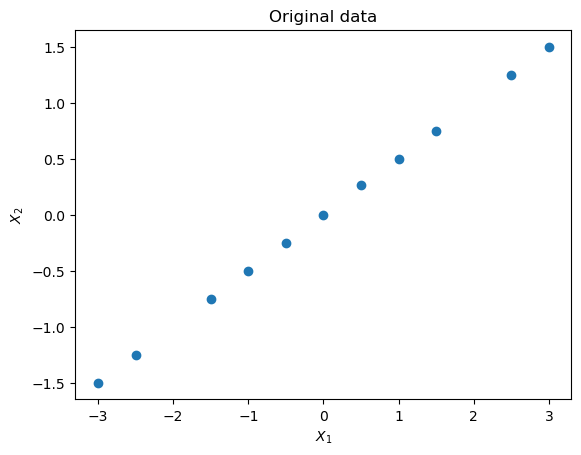

In [16]:
#Let's plot the original (i.e. unscaled) data
fig, ax = plt.subplots()
ax.scatter(pca_example[:,0], pca_example[:,1])
ax.set_ylabel('$X_2$')
ax.set_xlabel('$X_1$')
ax.set_title('Original data')
plt.show()

To show what PCA can do, we will apply it to our dataset and take a sneak peek at the results (using PCA from *sklearn*). We expect the first principal component to lie along the $X_2 = X_1/2$ line because that is the direction along which the data varies the most. And given the way we constructed the dataset, there will be almost no variation along the second principal component except for the anomaly.

In [17]:
pca = decomp.PCA(n_components=2)
pca.fit(scaled_pca_example)

PCA(n_components=2)

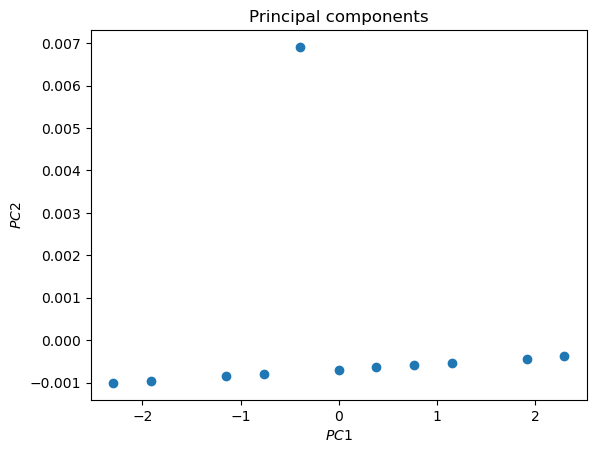

In [18]:
pca_example_trf = pca.transform(scaled_pca_example)
fig2, ax2 = plt.subplots()
ax2.scatter(pca_example_trf[:,0], pca_example_trf[:,1])
ax2.set_ylabel('$PC2$')
ax2.set_xlabel('$PC1$')
ax2.set_title('Principal components')
plt.show()

The anomaly is evident.

#### 2. Analysis
Now we'll proceed more formally. We create a function to carry out PCA on 2D data following the five steps we outlined at the beginning of this section.

Instead of doing the centering and mean normalization ourselves, we will use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) built into scikit-learn.

In [19]:
def get_1d_projected_vectors(obs, pca_object):
    # Note: The projection of vector a (data) along vector b (PC1)
    # is given by  [b / len(b)]* (len (a) cos (theta))
    # where theta is the angle between and b and the term in 
    # square parenthesis is a unit vector in the b direction
    #
    # Since cos (theta) = dot(a,b)/(len(a)len(b))
    # the projection can be written as
    # projs = b*[dot(a,b)/len(b)^2]
    #
    # The term in square parethenses is y_lengths
    # The projs is calculated adding back the mean
    # subtracted previously to center the data
    #
    # This is a very explicit way of handling the calculation.
    # See notes in "higher dimension" to see a way of generalizing
    # this to higher dimensions, while encapsulating the vector math.
    ssX = StandardScaler()
    centered_data = ssX.fit_transform(obs)
    pca_dirs = pca_object.components_
    
    y_lengths = centered_data.dot(pca_dirs.T) / pca_dirs.dot(pca_dirs.T)
    centered_projs = y_lengths*(pca_dirs)
    
    # Return the data to its original uncentered (and unscaled) positions
    return ssX.inverse_transform(centered_projs)

def do_pca_anomaly_scores(obs, pca_object):
    projected_vectors = get_1d_projected_vectors(obs, pca_object)    
    return nla.norm(obs-projs, axis=1)

In [20]:
def do_1d_pca_anomaly_scores(obs):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_ylabel('$X_2$')
    ax.set_xlabel('$X_1$')
    ax.set_title('Original data with PCA')
    
    # draw data
    ax.scatter(*obs.T, label='data')

    # Step 1: center and scale the data
    ssX = StandardScaler()
    centered_data = ssX.fit_transform(obs)
    mean = ssX.mean_
    
    #for completeness, show mean on plot
    ax.scatter(*mean.T, c='k', marker='^', label='mean') 

    # Step 2: compute prinicpal components
    # Here we focus on first PC  (greatest proportion of variance)
    pca = decomp.PCA(n_components=1)
    pca.fit_transform(centered_data)
    pca_dirs = pca.components_

    # draw principal components
    pca_endpoints = np.r_[-3.5*ssX.inverse_transform(pca_dirs),
                           3.5*ssX.inverse_transform(pca_dirs)]
    ax.plot(*pca_endpoints.T, 'y', label='PC1')

    # Step 3: Project our examples onto the PCs
    # 
    projs = get_1d_projected_vectors(obs, pca)
    ax.plot(*projs.T, 'r.', label='projected data')
    ax.legend(loc='best')
    
    # Step 4: Calculate distance between original and projected examples
    # Step 5: Use the distance to score the anomalies
    # The distance is the Euclidean norm and 
    # we use it as the anomaly score
    return nla.norm(obs-projs, axis=1)

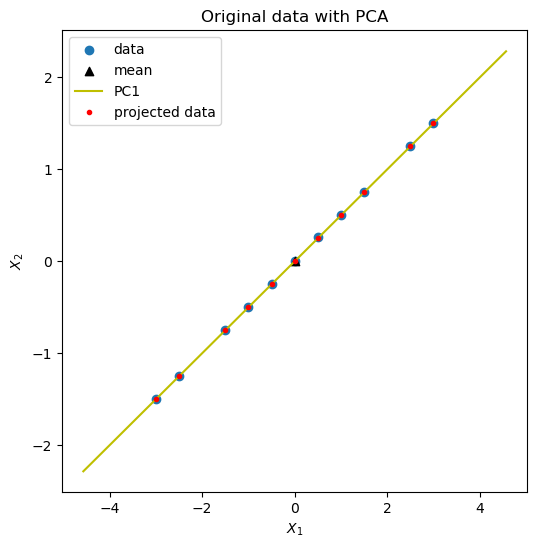

In [21]:
pca_example_scores = do_1d_pca_anomaly_scores(pca_example)

Because the data lies very close to PC1, it is hard to see the anomaly. Therefore, we look at the anomaly scores. 

In [22]:
print(pca_example_scores)

[0.0006 0.0006 0.0008 0.0009 0.0009 0.001  0.0101 0.0012 0.0012 0.0014
 0.0015]


We see one score (0.0101) which is much larger than the others. To what point does it correspond? 

In [23]:
print(pca_example[np.argmax(pca_example_scores)])

[0.5  0.26]


It is the anomaly in the data. PCA worked!

We repeat the analysis with noisier data: two Gaussian clusters seeded with two anomalies at (6.0, 6.0) and (0.0, 10.0).

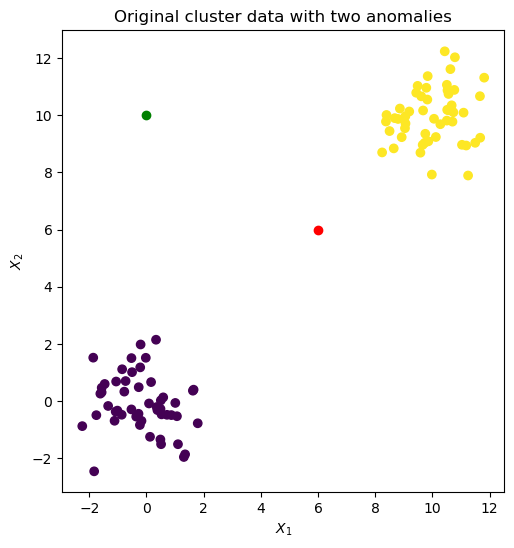

In [24]:
blobs_X, y = sk_data.make_blobs(centers=[[0,0], [10,10]])
figure, axes = plt.subplots(figsize=(6,6))
axes.scatter(*blobs_X.T, c=y)

spike_1 = np.array([[6.0,6.0]]) # Anomaly 1
spike_2 = np.array([[0.0,10]])  # Anomaly 2
axes.scatter(*spike_1.T, c='r')
axes.scatter(*spike_2.T, c='g')
axes.set_aspect('equal')
axes.set_ylabel('$X_2$')
axes.set_xlabel('$X_1$')
axes.set_title('Original cluster data with two anomalies')

# Combine the data so that the last two points are the anomalies
cluster_data = np.concatenate([blobs_X, spike_1, spike_2])

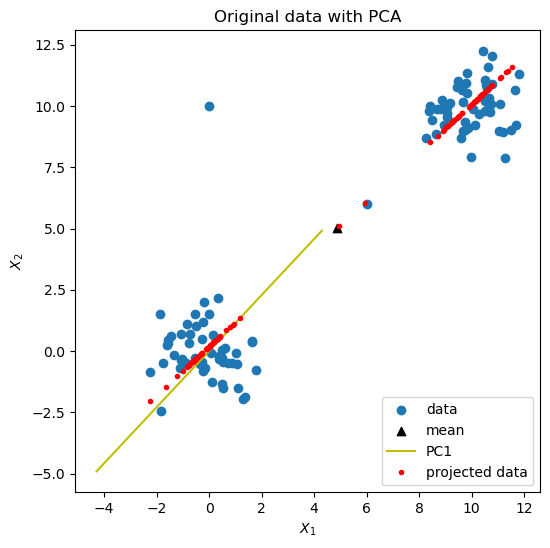

In [25]:
cluster_data_scores = do_1d_pca_anomaly_scores(cluster_data)

In [26]:
print(cluster_data_scores)
print(cluster_data_scores.shape)

[0.6456 0.2266 0.9287 0.5814 0.9001 1.3005 0.565  0.4515 1.3206 0.8299
 1.5635 0.6027 0.2898 1.1001 0.7533 0.6241 0.137  0.8333 0.2863 0.502
 0.8871 1.2573 0.7749 0.254  2.406  0.6949 0.3452 1.0928 0.4034 1.0078
 0.6717 0.3432 1.9445 0.5918 1.4296 1.2279 1.7924 0.6055 0.6889 0.5454
 2.4338 0.6864 1.0358 0.9413 0.1853 0.3973 0.3298 1.9792 0.4995 0.7107
 0.3438 0.9774 0.4571 1.1882 0.2515 1.1072 0.684  0.0328 0.648  2.2563
 0.8597 0.9087 0.7597 0.6049 0.2546 1.5199 0.554  0.0752 1.1581 1.0778
 0.5317 1.1871 1.3058 0.3985 1.4192 0.4683 0.7969 0.3635 1.0156 0.069
 2.4411 0.2949 1.7956 0.0311 0.5547 0.6943 0.4761 0.9603 1.5184 0.1928
 0.824  0.1526 0.2846 0.1629 0.8792 1.2577 0.2657 1.0305 1.6422 0.7506
 0.0895 6.9743]
(102,)


In [27]:
# The point with the highest scored is one of our seeded anomalies.
print(max(cluster_data_scores))
print(cluster_data[np.argmax(cluster_data_scores)])

6.974255405908584
[ 0. 10.]


Because of the way we constructed our dataset, we know that the last two points are the anomalies. 

The one at (0.0, 10.0), which has index=101, is the one we found above. 

The other one (6.0, 6.0), with index=100, has an anomaly score of 0.0886, which is very low. This is because it lies very close to PC1.


This example shows the limitations of PCA for anomaly detection with clustered data. For such data, proximity methods should also be tried (see lesson 4).

#### 3. Higher Dimension
In the function `do_pca_anomaly_scores` we called the helper function `get_projected_vectors` which found the projection of the vectors in our dataset onto the principal direction. By subtracting the projected vector from the original vector, we could find the length of the orthogonal components that we used to score. 

The approach used worked with one principal direction, and relied heavily on vector math. We can ask the (fitted) `pca` object to do the heavy lifting for us:
1. `reduced = pca.tranform(X)` will take our $N$-dimensional vectors, and project them onto the $d$-dimensional subspace. In our example, $N=2$ and $d=1$.
2. `projected = pca.inv_transform(reduced)` will embed the reduced vectors back into our $N$-dimensional subspace
3. `X - projected` are the components of the vectors that don't lie in our subspace.

In [28]:
def get_projected_vectors(X, pca, ssX=None):
    if not ssX:
        ssX = StandardScaler().fit(X)
    centered_data = ssX.transform(X)
    reduced = pca.transform(centered_data)
    # To get back to the original space, we need to undo the PCA
    # as well as undo the scaling/centering step.
    return ssX.inverse_transform(pca.inverse_transform(reduced))

In [29]:
# Show that it does the same thing as the previous version
def do_pca_anomaly_scores(obs, n_components=1):
    ssX = StandardScaler()
    centered_data = ssX.fit_transform(obs)
    pca = decomp.PCA(n_components=n_components)
    pca.fit(centered_data)
    
    projected_vectors = get_projected_vectors(obs, pca)
    return nla.norm(obs - projected_vectors, axis=1)

# check that the two answers agree
do_pca_anomaly_scores(pca_example) - pca_example_scores

array([ 0.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0.,  0.])

Our higher dimensional analog returns the same result as doing the vector arithmetic manually!

#### 4. Caution
- As with linear regression, anomalies can affect the modeling.
    - Ideally, find PCs with only normal data.
    - If this is not possible, after detecting anomalies, remove them from data and repeat analysis to check PCs haven't changed significantly.
    
- Preprocessing of data may be needed.
- Also not all data patterns are suitable for PCA.

## E. Section 3.  Support Vector Machines
- SVMs are supervised learning models used for classification.
- Typically used to classify data in two classes.
- It find the hyperplane with largest separation(margin) between two classes.

#### Next Steps
- What if you can't neatly separate the classes?
    - Not linearly separable (No suitable hyperplane)
- Transform data to high dimensional space where data is linearly separable.
- This transformation is called `kernel trick`.
    - Use kernel function to efficiently  calculate decision boundary.
- Choice of kernel will depend on the type of data.

#### SVM and Anomaly Detection
**Two Approaches**
1. Have labeled normal data and anomalies
    - Use SVM as a supervised learning model.
    
2. Have unlabeled data
    - Use one class SVMs.
    - Since data is unlabeled require assumptions to proceed.
    
#### One Class SVM
**Two key assumptions**
1. Data provided all belong to normal class
    - Since data may contain anomalies this results in a noisy model.
2. The origin belongs to the anomaly class
    - Origin is the kernel based transformed data.

One-class SVM typically returns anomalies (-1) or normal points (+1).  We, however, are interested in scoring our points and then ranking them by score.  Therefore, we will use the `decision_function` provided which returns the signed distance to separating hyperplane (negative distances are anomalies). To be consistent with out previous convention, where larger positive scores reflect more anomalous points, we need to take the negative of the `decision_function` .

In [30]:
def do_svm_anomaly_scores(obs):
    oc_svm = svm.OneClassSVM(gamma='auto').fit(obs)
    scores = oc_svm.decision_function(obs).flatten()
    
    # Find the largest score and use it to normalize the scores
    max_score = np.max(np.abs(scores))
    
    # scores from oc_svm use "negative is anomaly"
    # To follow our previous convention
    # we multiply by -1 and divide by the maximum score to get scores
    # in the range [-1, 1] with positive values indicating anomalies
    return - scores / max_score

Apply the one-class SVM to the cluster dataset of the previous section.
Look at both the raw scores and the top five points (by score).

In [31]:
print(do_svm_anomaly_scores(cluster_data))
print (do_svm_anomaly_scores(cluster_data).argsort()[-5:])

[ 0.0945 -0.      0.0798 -0.0711  0.0264  0.013   0.018   0.      0.
  0.2802  0.0482  0.0213 -0.0535 -0.0631  0.268  -0.0563  0.     -0.0672
 -0.0143 -0.0117  0.0313 -0.0058 -0.     -0.0446  0.256  -0.0468 -0.0243
 -0.0483 -0.0598  0.3446 -0.0522 -0.0209  0.2611  0.8517  0.      0.3635
  0.2024 -0.0025 -0.0231 -0.0123  0.4898 -0.0188  0.0725 -0.0418 -0.0296
  0.4273 -0.0115  0.0634 -0.0001 -0.0066 -0.0377 -0.0622 -0.0396  0.
 -0.0297  0.0405 -0.0091  0.0001 -0.0918  0.4571  0.      0.0066  0.044
 -0.0591  0.32    0.0451 -0.0001 -0.0257  0.4282  0.11   -0.0487  0.0126
  0.075  -0.0897  0.2638 -0.0207 -0.0153 -0.0131  0.3245  0.1185  0.2848
 -0.0885  0.1482 -0.0398  0.0109  0.0867 -0.0181  0.1021  0.4206 -0.0282
  0.4633 -0.0467 -0.0072  0.0793 -0.0781 -0.0184 -0.0138  0.0814  0.074
  0.1525  0.9995  1.    ]
[ 90  40  33 100 101]


The two seeded anomalies (index=100 and 101) are the two highest ranked points. The performance is better than PCA, but the process of anomaly detection is less transparent.

## Exercises

### Data
For all of the exercises, we will use a real-world dataset: the `ionosphere` dataset from the UCI Machine Learning Database repository. 
This dataset consists of radar returns from the ionosphere and was originally used to classify the returns as good (suitable for further research) or bad. More information is available here: https://archive.ics.uci.edu/ml/datasets/ionosphere.

For the purposes of this notebook, we have adapted the dataset for anomaly detection. We removed two columns: one with the class labels (good or bad) and another which was a constant (0) for all data instances. 

We read the data in as a pandas dataframe and then place it in numpy array for compatibility with our existing functions


In [32]:
ion_df = pd.read_csv('ionosphere_data.csv', header=None)
ion_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,1,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,0.85243,...,0.56811,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300
1,1,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,0.50874,...,-0.20332,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447
2,1,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,0.73082,...,0.57528,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238
3,1,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,0.00000,...,1.00000,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000
4,1,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,0.52798,...,0.03286,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697
5,1,0.02337,-0.00592,-0.09924,-0.11949,-0.00763,-0.11824,0.14706,0.06637,0.03786,...,0.03513,-0.01535,-0.03240,0.09223,-0.07859,0.00732,0.00000,0.00000,-0.00039,0.12011
6,1,0.97588,-0.10602,0.94601,-0.20800,0.92806,-0.28350,0.85996,-0.27342,0.79766,...,0.22792,-0.81634,0.13659,-0.82510,0.04606,-0.82395,-0.04262,-0.81318,-0.13832,-0.80975
7,0,0.00000,0.00000,0.00000,0.00000,1.00000,-1.00000,0.00000,0.00000,-1.00000,...,1.00000,1.00000,1.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000
8,1,0.96355,-0.07198,1.00000,-0.14333,1.00000,-0.21313,1.00000,-0.36174,0.92570,...,0.85106,-0.65440,0.57577,-0.69712,0.25435,-0.63919,0.45114,-0.72779,0.38895,-0.73420
9,1,-0.01864,-0.08459,0.00000,0.00000,0.00000,0.00000,0.11470,-0.26810,-0.45663,...,-0.14803,-0.01326,0.20645,-0.02294,0.00000,0.00000,0.16595,0.24086,-0.08208,0.38065


In [33]:
ion_df[0].unique()

array([1, 0])

In [34]:
ion_data = np.array(ion_df.values)
ion_data.shape

(351, 33)

In [35]:
ion_data

array([[ 1.    ,  0.9954, -0.0589, ..., -0.5449,  0.1864, -0.453 ],
       [ 1.    ,  1.    , -0.1883, ..., -0.0629, -0.1374, -0.0245],
       [ 1.    ,  1.    , -0.0336, ..., -0.2418,  0.5605, -0.3824],
       ...,
       [ 1.    ,  0.947 , -0.0003, ...,  0.0044,  0.927 , -0.0058],
       [ 1.    ,  0.9061, -0.0166, ..., -0.0376,  0.874 , -0.1624],
       [ 1.    ,  0.8471,  0.1353, ..., -0.0668,  0.8576, -0.0615]])

### Exercise #1
This exercise refers to Section 1 (linear regression model)
 
For the ionosphere dataset, there isn't a natural dependent variable, so we have to choose one. Create a function `linreg_anomaly_scores` that returns the anomalies scores of a linear regression model where two inputs are provided: the data and the index of the feature that is the dependent variable. We will use this function in Exercise 4 to analyze the ionosphere data.

**Note 1:** Note that since we don't have separate training data, for simplicity you should score the anomalies on all of the data.

**Note 2:** You may wish to use the following helper function. For data with _n_ features, it returns an array of length _n_ with all entries `False` except for a single `True` values at a specified index (_idx_).

In [36]:
def idx_to_boolean(n, idx):
    select = np.zeros(n,dtype=np.bool)
    select[idx] = True
    return select

In [37]:
def linreg_anomaly_scores(data, dep_var_index):
    # Extract the dependent variable column
    y = data[:, dep_var_index]
    # Extract independent variables (all other columns)
    X = np.delete(data, dep_var_index, axis=1)
 
    lr_train = linear_model.LinearRegression().fit(X, y)
    anom_score = (y - lr_train.predict(X))**2
    return anom_score

In [38]:
linreg_anomaly_scores(ion_data, 0)

array([0.0112, 0.003 , 0.0005, 0.0597, 0.0008, 0.0474, 0.0007, 0.4391,
       0.0008, 0.0049, 0.0001, 0.0318, 0.    , 0.0146, 0.0036, 0.0249,
       0.    , 0.1849, 0.0082, 0.9401, 0.0005, 0.0271, 0.0004, 0.0049,
       0.0048, 0.    , 0.0669, 0.418 , 0.0032, 0.1865, 0.    , 0.0236,
       0.0003, 0.0645, 0.0048, 0.0786, 0.0001, 0.0424, 0.0002, 0.106 ,
       0.0001, 0.126 , 0.0005, 0.0002, 0.0002, 0.2171, 0.0005, 0.0004,
       0.0007, 0.0329, 0.0257, 0.1624, 0.0006, 0.0036, 0.0004, 0.0443,
       0.0196, 0.2333, 0.0004, 0.0004, 0.    , 0.0631, 0.0001, 0.0611,
       0.0007, 0.0097, 0.0109, 0.2056, 0.0004, 0.0003, 0.0002, 0.3785,
       0.0001, 0.0184, 0.0014, 0.9533, 0.0004, 0.0028, 0.0002, 0.0794,
       0.0001, 0.0541, 0.    , 0.0126, 0.    , 0.0394, 0.0066, 0.0554,
       0.0045, 0.0067, 0.002 , 0.0488, 0.0109, 0.1099, 0.0178, 0.0086,
       0.0003, 0.0017, 0.0036, 0.0005, 0.2777, 0.0003, 0.389 , 0.0036,
       0.1259, 0.0162, 0.0196, 0.001 , 0.1175, 0.0079, 0.0001, 0.0005,
      

### Exercise #2

This exercise refers to Section 2 (PCA).

Create a function `pca_anomaly_scores` that  returns the anomalies scores of a PCA model where two inputs are provided: the data and the number of components. We will use this function in Exercise 4 to analyze the ionosphere data.

In [39]:
def pca_anomaly_scores(data, n_components):
    ssX = StandardScaler()
    centered_data = ssX.fit_transform(data)
    
    # Create a PCA model with the specified number of components
    pca = decomp.PCA(n_components=n_components)
    pca.fit(centered_data)
    
    projected_vectors = get_projected_vectors(data, pca)
    return nla.norm(data - projected_vectors, axis=1)

In [40]:
print(pca_anomaly_scores(ion_data, 1))

[1.6655 3.0215 0.9706 3.7495 2.0239 1.2688 2.8936 3.9783 2.2142 1.7674
 2.7707 3.2269 1.7502 2.1896 1.2706 3.5072 0.605  5.4911 1.3009 4.8738
 1.3296 4.311  0.6044 4.5721 1.0588 3.6923 2.9178 4.7728 3.2612 5.4724
 1.8629 3.5668 1.7038 2.6336 1.5932 3.0585 0.6473 4.7818 0.5763 1.8465
 2.5117 4.9513 2.0708 4.0615 2.2162 3.7134 1.3045 3.2093 0.7049 3.3185
 1.5106 4.46   4.1252 5.4828 1.1372 3.7646 1.3647 5.2698 0.8877 3.7875
 1.4355 2.7501 2.2974 3.8761 1.41   1.757  1.0036 3.917  3.2225 3.9024
 2.2583 4.9194 2.7824 1.9261 2.2507 4.4572 2.0037 5.3094 4.1342 4.8316
 2.4739 4.1272 2.5601 1.5309 0.6085 1.7648 0.62   2.1687 0.646  1.5976
 1.7568 2.913  0.9545 2.4975 0.83   3.0677 2.8549 2.8316 4.4656 0.5678
 4.0429 0.7361 1.7507 1.0608 2.419  1.523  2.0298 0.6522 2.5024 3.1461
 2.815  2.4814 2.551  2.6148 1.881  0.7902 1.1307 0.66   2.9556 0.763
 1.4638 2.0176 2.5324 0.8149 3.3503 2.1197 2.5168 0.57   2.913  0.5052
 2.0086 0.69   3.5702 1.8627 3.1994 2.421  3.472  0.8909 1.4243 1.2248
 3.9462

### Exercise #3
This exercise refers to Section 3 (one-class SVM).

Create a function `svm_anomaly_scores` that returns the anomalies scores of a one-class SVM model where two sets inputs are provided: the data and a kernel. We will use this function in Exercise 4 to analyze the ionosphere data.

In [41]:
def svm_anomaly_scores(data, kernel="linear"):
    oc_svm = svm.OneClassSVM(kernel=kernel, gamma='auto').fit(data)
    scores = oc_svm.decision_function(data).flatten()
    
    # Find the largest score and use it to normalize the scores
    max_score = np.max(np.abs(scores))
    
    # scores from oc_svm use "negative is anomaly"
    # To follow our previous convention
    # we multiply by -1 and divide by the maximum score to get scores
    # in the range [-1, 1] with positive values indicating anomalies
    return - scores / max_score

In [42]:
print(svm_anomaly_scores(ion_data))

[-0.0823  0.2953 -0.1681  0.1154  0.0042  0.4854  0.0113  0.7038 -0.1387
  0.5075 -0.1204 -0.2202 -0.2015 -0.2383 -0.2805  0.3483 -0.2262  0.7761
  0.0414  0.3738 -0.2357  0.7377 -0.1628  0.5786 -0.2212 -0.0839 -0.1563
  1.     -0.2799  0.4875 -0.2732 -0.0629 -0.1077 -0.1171 -0.1867 -0.0973
 -0.2542  0.6056 -0.1882 -0.0687 -0.1289  0.2905 -0.0539  0.052  -0.1726
  0.6046 -0.2376  0.2083 -0.2267  0.3331 -0.1549  0.2165 -0.2638  0.5812
 -0.2505  0.5194 -0.3038  0.6004 -0.2481  0.5023 -0.2187  0.2951 -0.1637
 -0.0072 -0.2898 -0.2306 -0.3043  0.0543 -0.1445 -0.2837 -0.2817  0.2967
 -0.1455  0.2709 -0.2121  0.1078 -0.2091 -0.     -0.3131  0.2274 -0.3305
 -0.1502 -0.0668  0.0947 -0.0707 -0.0189 -0.0705 -0.1197  0.1018  0.3096
 -0.1487  0.1755  0.      0.3589  0.0949  0.2732  0.1096  0.1045  0.6235
 -0.0869  0.3101 -0.2703  0.5866 -0.2011  0.1277 -0.2835  0.2264 -0.2097
  0.0704 -0.0639  0.      0.0935  0.0203  0.0455  0.3622  0.2503 -0.0785
 -0.1254  0.3365 -0.2249  0.2365 -0.1829  0.3816  0

### Exercise #4
We now have three `[method]_outlier_scores` functions.  Apply each of them to the ionosphere dataset.  What are the top five most anomalous examples using each technique?

In [43]:
methods = [linreg_anomaly_scores,
           pca_anomaly_scores,
           svm_anomaly_scores]

def find_top_anomalies(scores, k=5):
    # Find the indices of the top k anomalies
    top_anomalies_indices = np.argsort(scores)[-k:][::-1]
    return top_anomalies_indices

# Linear Regression Anomaly Scores
linreg_scores = methods[0](ion_data, 1)
top_linreg_anomalies = find_top_anomalies(linreg_scores)
print("Top 5 anomalies using Linear Regression:")
print(top_linreg_anomalies)

# PCA Anomaly Scores
num_components_pca = 2  # Choose the number of components
pca_scores = methods[1](ion_data, num_components_pca)
top_pca_anomalies = find_top_anomalies(pca_scores)
print("\nTop 5 anomalies using PCA:")
print(top_pca_anomalies)

# SVM Anomaly Scores
svm_scores = methods[2](ion_data, kernel="linear")
top_svm_anomalies = find_top_anomalies(svm_scores)
print("\nTop 5 anomalies using SVM:")
print(top_svm_anomalies)

Top 5 anomalies using Linear Regression:
[184  57 170  17 136]

Top 5 anomalies using PCA:
[ 17  53 162  57 220]

Top 5 anomalies using SVM:
[ 27 204 188 232 210]


Three different methods, three different answers. Therefore more exploration is needed, which we encourage the reader to pursue. For example, choosing different target feature for the linear regression; increase the number of components in PCA; or change the kernel for one-class SVM. 

In [44]:
print(sorted(do_svm_anomaly_scores(ion_data).argsort()[-5:]))

[17, 29, 53, 162, 220]
